# Using XENON fuse

## Imports

In [1]:
import strax
import straxen
import cutax
import fuse

import numpy as np
from straxen import URLConfig

/Users/henningse/miniforge3/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
2023-08-16 17:32:22,907 - utilix - WARNING - Could not load a configuration file. You can create one at /Users/henningse/.xenon_config, or set a custom path using

export XENON_CONFIG=path/to/your/config



/Users/henningse/Code/straxen/straxen/plugins/led_cal/led_calibration.py:213: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def calc_delta_time(ext_timings_nv_delta_time, pulses, hitlets_nv, nv_pmt_start, nv_pmt_stop):


/Users/henningse/miniforge3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'cutax'

## Microphysics simulation (former epix)

In fuse all simulation steps are handled in dedicated plugins just like straxen does for our data processing. The first part of our full chain simulations is the simulation of microphysics effects. The corresponding plugins are grouped in the `micro_physics` module.

To set up a simulation we first need to define a `Context`. At this stage we dont't need a lot of inputs so we can run the simulation inside a generic `strax.Context`. fuse has a predefined `microphyics_context` that registers all needed plugins for us. Afterwards we can change the configuration of the simulation using `st.set_config`. If you want to try your own `.root` or `.csv`file feel free to change the given example file.

There are some more options we can change: 
- `debug` will print out some debug informations during the simulation (For now there are basically no debug statements.)
- `source_rate`: You can specify a rate in Hz. fuse will distribute your events according to this rate. 
- `n_interactions_per_chunk`: fuse builds strax chunks based on an algorithm called 'dynamic chunking'. It searches for empty time intervalls and cuts the data into chunks there. With this parameter you can set an lower limit to the number of interactions per chunk. For Geant4 files something in the order of 10k - 100k can work. For csv files i would reccomend something in the order of 10 - 1000 depending on you specific data. 
- `cut_delayed`: fuse will remove interactions that happen after the last sampled time + the cut_delayed time. We dont want to deal with interactions that happen way after our "run" finished (yet)

In [2]:
st = fuse.context.microphysics_context("/path/to/output/folder")

st.set_config({"path": "/project2/lgrandi/xenonnt/simulations/testing",
               "file_name": "pmt_neutrons_100.root",
               "debug": True,
               "source_rate": 1,
              })

NameError: name 'fuse' is not defined

Now that we have our context we can start to run fuse. Just use `st.make` and pick the data types you would like to make.

In [3]:
run_number = "00000"

st.make(run_number, "geant4_interactions")
st.make(run_number, "cluster_index")
st.make(run_number, "clustered_interactions")
st.make(run_number, "electric_field_values")
st.make(run_number, "quanta")
st.make(run_number, "microphysics_summary")

NameError: name 'st' is not defined

If your simulation did not crash you can now load the simulated data just like straxen data. First we can take a look at the `geant4_interaction`. Each line represents a single energy deposit. 

In [4]:
geant4_interactions = st.get_df("00000",["geant4_interactions", "cluster_index"])
geant4_interactions.head(10)

NameError: name 'st' is not defined

You can also load the clustered data that will go into the second part of the simulation. For now it is called `microphysics_summary`. Each line gives you now the position and number of electron and photons (along other informations.)

In [5]:
microphysics_summary = st.get_df("00000",[ "microphysics_summary"])
microphysics_summary.head(10)

NameError: name 'st' is not defined

## Detector and Electronics Simulation (former WFSim)

Now that you know how to run microphysics simulations we can continue with the detector physics, PMT and DAQ simulations. The corresponding plugins can be found in the`detector_physics` and `pmt_and_daq` modules. 

We want to simulate now up to the raw_records level and then process the data with our usual straxen processing routines. To do so, we will use the `full_chain_context` that is prepared in fuse. To build the context you need to provide a config dictionary, we will load our XENONnT SR0 config here. Remember to select an output folder with sufficient free disk space as `propagated_s2_photons` and `raw_records` data can be a bit heavy. 

In [6]:
url_string = 'simple_load://resource://format://fax_config_nt_sr0_v4.json?&fmt=json'
config = URLConfig.evaluate_dry(url_string)

NameError: name 'URLConfig' is not defined

In [7]:
st = fuse.context.full_chain_context(out_dir = "/path/to/output/folder",
                                     config = config)

st.set_config({"path": "/project2/lgrandi/xenonnt/simulations/testing",
               "file_name": "pmt_neutrons_100.root",
               "debug": True,
               "source_rate": 1,
              })

NameError: name 'fuse' is not defined

### Microphysics
Just like before we first run the microphysics simulation. Lets make `microphysics_summary` first. Note that you dont need to make every data type manually but let strax take care of it.

In [8]:
run_number = "00000"

st.make(run_number,"microphysics_summary")

NameError: name 'st' is not defined

### S1 Simulation

After the microphysics simulation is done we can continue and distribute our S1 photons to our PMTs. First we need to determin how many photons are actually recorded at an PMT. This step is quite fast and can be used in fastsim in the future (I guess).

In [9]:
st.make(run_number,"s1_photons" ,progress_bar = True)

NameError: name 'st' is not defined

In a second step we distribute the photons to our PMTs. The output will be a long list where each row represents a single photon with the information of `time` and `channel`attached.  Strax can show you a progress bar during simulation. I found it to be a bit buggy misleading as it shows the fraction of simulated time and not number of interactions. 

In [10]:
st.make(run_number,"propagated_s1_photons" ,progress_bar = True)

NameError: name 'st' is not defined

### S2 Simulations

The S2 simulations are a bit more complicated than the S1 simulation and thus split into more plugins. We first need to drift our electrons to the liquid-gas interface, extract them and calculate the timing of the electrons when reaching the gas phase. Afterwards we can simulate how many photons each electron generates and then distribute the photons on the PMTs. The output of the S2 simulation has basically the same format as the S1 simulation output. 

In [11]:
st.make(run_number,"drifted_electrons",progress_bar = True)
st.make(run_number,"extracted_electrons",progress_bar = True)
st.make(run_number,"electron_time",progress_bar = True)
st.make(run_number,"s2_photons",progress_bar = True)
st.make(run_number,"s2_photons_sum",progress_bar = True)
st.make(run_number,"propagated_s2_photons",progress_bar = True)

NameError: name 'st' is not defined

### PMT Afterpulses

Based on the output of the S1 and S2 simulation we can calculate PMT afterpulses. The output will have the same format as the S1 and S2 simulations where each row represents a "virtual" photon with information about channel and timing attached. 

In [12]:
st.make(run_number,"pmt_afterpulses",progress_bar = True)

NameError: name 'st' is not defined

### PMT and DAQ

Combining our S1, S2 and AP simulations we can start to simulate the PMT response to photons and simulate the effects of our DAQ on the PMT output. As a result we get `raw_records` that sould look very similar to the data we get from our real TPC and DAQ! 

In [13]:
st.make(run_number,"raw_records" , progress_bar = True)

NameError: name 'st' is not defined

## Processing

We finished our simulation! Now we can use straxen to process it. All necessary straxen plugins should be already registered in the context. 

In [14]:
st.make(run_number,"event_info")

NameError: name 'st' is not defined

In [15]:
event_info = st.get_df(run_number, "event_info")

NameError: name 'st' is not defined

In [16]:
event_info.head(20)

NameError: name 'event_info' is not defined

If you take a look at the readme of fuse you will find that `S1PhotonHits`, `ElectronDrift`, `ElectronExtraction` and `SecondaryScintillation` produce data with the `interactions_in_roi` data_kind just like e.g. the microphysics_summary. As a result we can load this data togeter. For each interaction cluster we thus have the number of S1 and S2 photons. This can be exploited when integrating fastsim. 

## CSV Input

You can also run the simulation without a Geant4 root file but with simulation instructions in a csv file. Simulation instructions from csv files can be passed to fuse on the microphysics level and on the detector physics level.

### Microphysics

First we need to generate some simulation instructions and save them to a csv file. Below you find two examples, one function generating monoenergetic energy deposits from a gamma source and a second function to mimic Kr83m decays.

In [17]:
import pandas as pd
import numpy as np

def monoenergetic_source(n, energy):
    
    df = pd.DataFrame()
    
    r = np.sqrt(np.random.uniform(0, 2500, n))
    t = np.random.uniform(-np.pi, np.pi, n)
    df['xp'] = r * np.cos(t)
    df['yp'] = r * np.sin(t)
    df['zp'] = np.random.uniform(-150, 0, n)
    
    df['xp_pri'] = df['xp']
    df['yp_pri'] = df['yp']
    df['zp_pri'] = df['zp']
    
    df["ed"] = np.array([energy]*n)
    df["time"] = np.zeros(n)
    df["evtid"] = np.arange(n)
    
    df["type"] = np.repeat("gamma", n)
    
    df["trackid"] =  np.zeros(n)
    df["parentid"] = np.zeros(n, dtype = np.int32)
    df["creaproc"] = np.repeat("None", n)
    df["parenttype"] = np.repeat("None", n)
    df["edproc"] = np.repeat("None", n)
    
    return df

def Kr83m_example(n):
    
    half_life = 156.94e-9 #Kr intermediate state half-life in ns
    decay_energies = [32.2,9.4] # Decay energies in kev
    
    df = pd.DataFrame()
    
    r = np.sqrt(np.random.uniform(0, 2500, n))
    t = np.random.uniform(-np.pi, np.pi, n)
    df['xp'] = np.repeat(r * np.cos(t), 2)
    df['yp'] = np.repeat(r * np.sin(t), 2)
    df['zp'] = np.repeat(np.random.uniform(-150, 0, n), 2)
    
    df['xp_pri'] = df['xp']
    df['yp_pri'] = df['yp']
    df['zp_pri'] = df['zp']
    
    df['ed'] = np.tile(decay_energies,n)
    
    dt = np.random.exponential(half_life/np.log(2),n)
    df['time'] = np.array(list(zip(np.zeros(n), dt))).flatten()#*1e9
    
    df["evtid"] = np.repeat(np.arange(n), 2)
    
    df["parenttype"] = np.tile(['Kr83[41.557]', 'Kr83[9.405]'], n)
    
    #Not used:
    # a) since Kr83m is classified in epix using only the parenttype
    # b) trackid, parentid are not used right now.
    # Please keep in mind that other "simulations" may require properly set 
    # edproc, type and creaproc. Future epix updates using e.g. track reconstructions
    # may also need proper track- and parent-ids. 
    df["trackid"] = np.tile([0,1], n)
    df["parentid"] = np.zeros(2*n, dtype = np.int32)
    df["creaproc"] = np.repeat("None", 2*n)
    df["edproc"] = np.repeat("None", 2*n)
    df["type"] = np.repeat("None", 2*n)

    return df

The time fuse needs to simulate depends on the energy of the signal you put into fuse. The higher the energy the longer fuse needs to simulate. In this example we will simulate 1000 events with an energy of 200 keV. 

In [18]:
microphysics_instructions = monoenergetic_source(1000, 200)
microphysics_instructions.to_csv("monoenergetic_200keV.csv")

We can use the full_chain_context again as fuse will automatically detect that a csv file is given and treat it accordingly. As our csv file contains a single energy deposit per event, we should set `n_interactions_per_chunk` to something reasonable like 100. Now each chunk will consist of at least 100 events. 

In [19]:
st = fuse.context.full_chain_context(out_dir = "/path/to/output/folder",
                                     config = config)

st.set_config({"path": ".",
               "file_name": "monoenergetic_200keV.csv",
               "debug": True,
               "source_rate": 1,
               "n_interactions_per_chunk": 100,
               "cut_delayed": 4e14,
              })

run_number = "00001"

NameError: name 'fuse' is not defined

We do not need to run each simulation step manualy, strax will handle that. Lets just ask it to make `raw_records` and then `event_info`.

In [20]:
st.make(run_number,"raw_records" , progress_bar = True)

NameError: name 'st' is not defined

In [21]:
st.make(run_number,"event_info" , progress_bar = True)

NameError: name 'st' is not defined

In [22]:
event_info_data = st.get_df(run_number,"event_info")

NameError: name 'st' is not defined

Lets end this subsection with an unnecessary complicated scatterplot. 

NameError: name 'event_info_data' is not defined

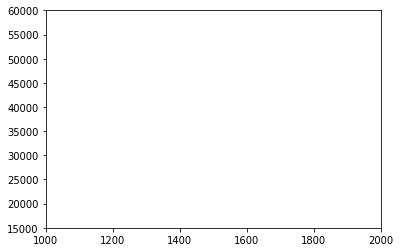

In [23]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

fig = plt.figure()
ax = fig.gca()
ax.set_xlim(1000, 2000)
ax.set_ylim(15000, 60000)

xdata = event_info_data["cs1_wo_timecorr"].values
ydata = event_info_data["cs2_wo_timecorr"].values

xy = np.vstack([xdata, ydata])
z = gaussian_kde(xy)(xy)

ax.scatter(xdata,
           ydata,
           c=z,
           s=7.5,
           cmap="viridis"
          )

ax.set_xlabel("cS1 [pe]")
ax.set_ylabel("cS2 [pe]")

plt.show()

### Detector Physics

Now that we know how to start the microphysics simulation from a csv file we can do the same for the detector physics simulation.
The required csv file format is a bit different. You can find a very simple example below. 

In [24]:
import pandas as pd
def build_random_instructions(n):

    df = pd.DataFrame()
    
    r = np.sqrt(np.random.uniform(0, 2500, n))
    t = np.random.uniform(-np.pi, np.pi, n)
    df['x'] = r * np.cos(t)
    df['y'] = r * np.sin(t)
    df['z'] = np.random.uniform(-130, -15, n)

    df['photons'] = np.random.uniform(100,5000, n)
    df['electrons'] = np.random.uniform(100,5000, n)
    df["excitons"] = np.zeros(n)

    df['e_field'] = np.array([23]*n)
    df["nestid"] = np.array([7]*n)
    df["ed"] = np.zeros(n)

    #just set the time with respect to the start of the event
    #The events will be distributed in time by fuse
    df["t"] = np.zeros(n)

    df["eventid"] = np.arange(n)

    return df


In [25]:
detectorphysics_instructions = build_random_instructions(1000)
detectorphysics_instructions.to_csv("random_detectorphysics_instructions.csv",index=False)

We can now set up the simulation context. As i was to lazy to set up a context for this use case yet i just hijack the `full_chain_context` and register the `ChunkCsvInput` plugin. 

In [26]:
st = fuse.context.full_chain_context(out_dir = "/path/to/output/folder",
                                     config = config)


st.register(fuse.detector_physics.ChunkCsvInput)

st.set_config({"input_file": "./random_detectorphysics_instructions.csv",
               "debug": True,
               "source_rate": 1,
               "n_interactions_per_chunk": 25,
              })

run_number = "00002"

NameError: name 'fuse' is not defined

In [27]:
st.make(run_number,"raw_records" , progress_bar = True)

NameError: name 'st' is not defined

In [28]:
st.make(run_number,"event_info" , progress_bar = True)

NameError: name 'st' is not defined

In [29]:
event_info_data = st.get_df(run_number,"event_info")

NameError: name 'st' is not defined